# Multibin Coupled HistoSys


In [1]:
import json
import logging

import matplotlib.pyplot as plt
import numpy as np

import pyhf
from pyhf import Model

logging.basicConfig(level=logging.INFO)

In [2]:
def prep_data(sourcedata):
    spec = {
        "channels": [
            {
                "name": "signal",
                "samples": [
                    {
                        "name": "signal",
                        "data": sourcedata["signal"]["bindata"]["sig"],
                        "modifiers": [
                            {"name": "mu", "type": "normfactor", "data": None}
                        ],
                    },
                    {
                        "name": "bkg1",
                        "data": sourcedata["signal"]["bindata"]["bkg1"],
                        "modifiers": [
                            {
                                "name": "coupled_histosys",
                                "type": "histosys",
                                "data": {
                                    "lo_data": sourcedata["signal"]["bindata"][
                                        "bkg1_dn"
                                    ],
                                    "hi_data": sourcedata["signal"]["bindata"][
                                        "bkg1_up"
                                    ],
                                },
                            }
                        ],
                    },
                    {
                        "name": "bkg2",
                        "data": sourcedata["signal"]["bindata"]["bkg2"],
                        "modifiers": [
                            {
                                "name": "coupled_histosys",
                                "type": "histosys",
                                "data": {
                                    "lo_data": sourcedata["signal"]["bindata"][
                                        "bkg2_dn"
                                    ],
                                    "hi_data": sourcedata["signal"]["bindata"][
                                        "bkg2_up"
                                    ],
                                },
                            }
                        ],
                    },
                ],
            },
            {
                "name": "control",
                "samples": [
                    {
                        "name": "background",
                        "data": sourcedata["control"]["bindata"]["bkg1"],
                        "modifiers": [
                            {
                                "name": "coupled_histosys",
                                "type": "histosys",
                                "data": {
                                    "lo_data": sourcedata["control"]["bindata"][
                                        "bkg1_dn"
                                    ],
                                    "hi_data": sourcedata["control"]["bindata"][
                                        "bkg1_up"
                                    ],
                                },
                            }
                        ],
                    }
                ],
            },
        ]
    }
    pdf = Model(spec)
    data = []
    for c in pdf.config.channels:
        data += sourcedata[c]["bindata"]["data"]
    data = data + pdf.config.auxdata
    return data, pdf

In [3]:
validation_datadir = "../../../validation/data"

In [4]:
with open(validation_datadir + "/2bin_2channel_coupledhisto.json") as spec:
    source = json.load(spec)

data, pdf = prep_data(source["channels"])

print(f"data: {data}")

init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

unconpars = pyhf.infer.mle.fit(data, pdf, init_pars, par_bounds)
print(f"parameters post unconstrained fit: {unconpars}")

conpars = pyhf.infer.mle.fixed_poi_fit(0.0, data, pdf, init_pars, par_bounds)
print(f"parameters post constrained fit: {conpars}")

pdf.expected_data(conpars)

INFO:pyhf.pdf:Validating spec against schema: model.json
INFO:pyhf.pdf:adding modifier coupled_histosys (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier mu (1 new nuisance parameters)


data: [110.0, 105.0, 170.0, 220.0, 0.0]
parameters post unconstrained fit: [-0.30257894  0.63607078]
parameters post constrained fit: [0.29087602 0.        ]


array([106.80676913, 104.01075137, 154.36314037, 213.86871072,
         0.29087602])

In [5]:
def plot_results(test_mus, cls_obs, cls_exp, poi_tests, test_size=0.05):
    fig, ax = plt.subplots()
    ax.plot(poi_tests, cls_obs, c="k")
    for i, c in zip(range(5), ["grey", "grey", "grey", "grey", "grey"]):
        ax.plot(poi_tests, cls_exp[i], c=c)
    ax.plot(poi_tests, [test_size] * len(test_mus), c="r")
    ax.set_ylim(0, 1)

In [6]:
def invert_interval(test_mus, cls_obs, cls_exp, test_size=0.05):
    crossing_test_stats = {"exp": [], "obs": None}
    for cls_exp_sigma in cls_exp:
        crossing_test_stats["exp"].append(
            np.interp(
                test_size, list(reversed(cls_exp_sigma)), list(reversed(test_mus))
            )
        )
    crossing_test_stats["obs"] = np.interp(
        test_size, list(reversed(cls_obs)), list(reversed(test_mus))
    )
    return crossing_test_stats

In [7]:
poi_tests = np.linspace(0, 5, 61)
tests = [
    pyhf.infer.hypotest(
        poi_test, data, pdf, init_pars, par_bounds, return_expected_set=True
    )
    for poi_test in poi_tests
]
cls_obs = np.array([test[0] for test in tests]).flatten()
cls_exp = [np.array([test[1][i] for test in tests]).flatten() for i in range(5)]

/home/feickert/Code/GitHub/pyhf/src/pyhf/infer/calculators.py:418: RuntimeWarning: invalid value encountered in double_scalars
  teststat = (qmu - qmu_A) / (2 * self.sqrtqmuA_v)


{'exp': [0.3379557904310767,
  0.6355433028074602,
  0.980748685945719,
  1.4196566943996904,
  1.9446272307776151],
 'obs': 1.5452056912523955}

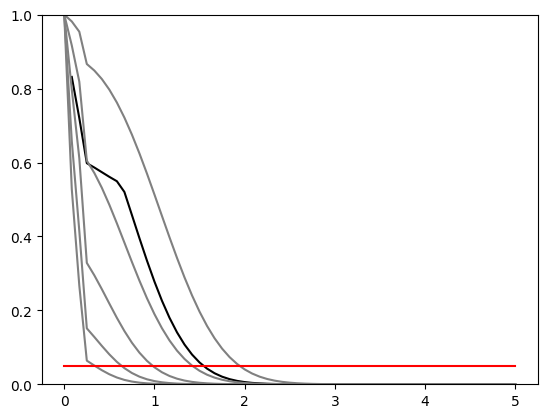

In [8]:
print("\n")
plot_results(poi_tests, cls_obs, cls_exp, poi_tests)
invert_interval(poi_tests, cls_obs, cls_exp)